In [2]:
import torch 
import numpy as np
import torch.nn as nn
from scipy.integrate import odeint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"
#device = torch.device("cpu")
print(device)
import matplotlib.pyplot as plt
from tqdm import tqdm

cuda


# Read Data

In [3]:
mdev=device

In [4]:
!ls *.pt

CUM_data_SD_county.pt	  SEIR_timedep_2weeks_model.pt	SIR_data_SD.pt
CUM_data_SD_county_v2.pt  SEIR_time.pt			SIR_test_sample.pt
SEIR_test_sample.pt	  SIR_data_SD_county.pt		SIR_time.pt


In [5]:
if device.type == 'cuda':
    SIR=torch.load("SIR_data_SD_county.pt").cuda()
else:
    SIR=torch.load("SIR_data_SD_county.pt").cpu()

In [6]:
#normalization 
npop=SIR[0,0].cpu().numpy().copy()
print("Total population: %d" % npop)
SIR[:,:] = SIR[:,:] / torch.tensor(npop, device=mdev)

Total population: 3338330


In [20]:
#torch.ones(1, device='cuda:0')
#torch.ones(1).cuda()
torch.rand(1, device=mdev)

tensor([0.4282], device='cuda:0')

In [21]:
#%%writefile seir.py
class Neural_ODE_SEIR(nn.Module):
    def __init__(self, solver = "Euler", initial='random'):
        super(Neural_ODE_SEIR, self).__init__()
        if initial == 'random':
            self.initial = torch.nn.Parameter(torch.rand(4, device=mdev)/10)
        else:
            self.initial = torch.nn.Parameter(initial)
        
        #print(self.initial)
            
        nt=500
        #self.beta = torch.nn.Parameter(torch.rand(nt)/10)
        #self.gamma = torch.nn.Parameter(torch.rand(nt)/10)
        #self.sigma = torch.nn.Parameter(torch.rand(nt)/10)
        self.beta = torch.nn.Parameter(torch.ones(nt, device=mdev)*0.05)
        self.gamma = torch.nn.Parameter(torch.ones(nt, device=mdev)*0.09)
        self.sigma = torch.nn.Parameter(torch.ones(nt, device=mdev)*0.04)
        #self.sigma = torch.nn.Parameter(torch.ones(1, device=mdev)*0.05)
        self.step = torch.tensor(1, device=mdev)
        self.solver = solver
        
    def Euler(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        E_pred = [self.initial[1].reshape(-1,1)]
        I_pred = [self.initial[2].reshape(-1,1)]
        R_pred = [self.initial[3].reshape(-1,1)]
        for n in range(len(t)-1):
            S_pred.append((S_pred[n] - self.beta[n][n]*S_pred[n]*I_pred[n]*self.step).reshape(-1,1))
            E_pred.append((E_pred[n] + (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma*E_pred[n])*self.step).reshape(-1,1))
            I_pred.append((I_pred[n] + (self.sigma*E_pred[n] - self.gamma[n]*I_pred[n])*self.step).reshape(-1,1))
            R_pred.append((R_pred[n] + self.gamma[n]*I_pred[n]*self.step).reshape(-1,1))
        y_pred = torch.cat([torch.cat(S_pred, dim = 0),
                            #torch.cat(E_pred, dim = 0),
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
    
    def RK4(self, t):
        S_pred = [self.initial[0].reshape(-1,1)]
        E_pred = [self.initial[1].reshape(-1,1)]
        I_pred = [self.initial[2].reshape(-1,1)]
        R_pred = [self.initial[3].reshape(-1,1)]
        
        for n in range(len(t)-1):
            k1 = self.beta[n]*S_pred[n]*I_pred[n]*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta[n]*(S_pred[n]+ k1/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta[n]*(S_pred[n]+ k2/2)*I_pred[n])*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta[n]*(S_pred[n]+ k3)*I_pred[n])*self.step #dt * f(t[n] + dt, y[n] + k3)            
            S_pred.append((S_pred[n] - 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma*E_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma*(E_pred[n] +  k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma*(E_pred[n] +  k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.beta[n]*S_pred[n]*I_pred[n] - self.sigma*(E_pred[n] +  k3))*self.step #dt * f(t[n] + dt, y[n] + k3)            
            E_pred.append((E_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            k1 = (self.sigma*E_pred[n] - self.gamma[n]*I_pred[n])*self.step #dt * f(t[n], y[n]) 
            k2 = (self.sigma*E_pred[n] - self.gamma[n]*(I_pred[n] + k1/2))*self.step #dt * f(t[n] + dt/2, y[n] + k1/2)
            k3 = (self.sigma*E_pred[n] - self.gamma[n]*(I_pred[n] + k2/2))*self.step #dt * f(t[n] + dt/2, y[n] + k2/2)
            k4 = (self.sigma*E_pred[n] - self.gamma[n]*(I_pred[n] + k3))*self.step #dt * f(t[n] + dt, y[n] + k3)   
            I_pred.append((I_pred[n] + 1/6 * (k1 + 2*k2 + 2*k3 + k4)).reshape(-1,1))
            
            R_pred.append((R_pred[n] + self.gamma[n]*I_pred[n]*self.step).reshape(-1,1))

        y_pred = torch.cat([torch.cat(S_pred, dim = 0), 
                            #torch.cat(E_pred, dim = 0),
                            torch.cat(I_pred, dim = 0), 
                            torch.cat(R_pred, dim = 0)], dim = 1)
        return y_pred
            
            
    def forward(self, t):
        if self.solver == "Euler":
            return self.Euler(t)
        elif self.solver == "RK4":
            return self.RK4(t)
        else:
            print("Error")        

In [22]:
t0=0
t1=374

In [23]:
time = torch.tensor(np.linspace(0, len(SIR)-1, len(SIR)), requires_grad=True, device=mdev).float()
myinit=torch.cat([SIR[t0,0].reshape(-1,1), 
                  (SIR[t0,1]*2).reshape(-1,1), 
                  SIR[t0,1].reshape(-1,1), 
                  SIR[t0,2].reshape(-1,1)])

if mdev.type == 'cuda':
    myinit = myinit.cuda()
myinit.device
#print(myinit)
model_ode_seir = Neural_ODE_SEIR(solver = "RK4", initial=myinit)
y_exact = SIR.float()

In [24]:
#scheduler?

In [25]:
optimizer = torch.optim.Adam(model_ode_seir.parameters(), 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma=0.95)
num_epochs = 100
loss_fun = torch.nn.MSELoss()
tqdm_epochs = tqdm(range(num_epochs))
min_loss = 10

for e in tqdm_epochs:
    y_approx = model_ode_seir(time[t0:t1])
    loss = loss_fun(y_approx, y_exact[t0:t1])
    if loss.item() < min_loss:
        best_model_ode_seir = model_ode_seir
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    tqdm_epochs.set_postfix({'loss': torch.sum(loss).item()})

  0%|          | 0/100 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (500) must match the size of tensor b (250000) at non-singleton dimension 0

In [13]:
#torch.nn.Parameter(torch.cat([SIR[t0,0].reshape(-1,1), SIR[t0,1].reshape(-1,1)]))

In [43]:
beta=best_model_ode_seir.beta.cpu().detach().numpy()
gamma=best_model_ode_seir.gamma.cpu().detach().numpy()
sigma=best_model_ode_seir.sigma.cpu().detach().numpy()
print("beta:", beta[::10])
print("sigma:", sigma)
#,gamma,sigma)

beta: [0.03153789 0.03813551 0.04127335 0.04403094 0.04703749 0.05039947
 0.05405989 0.05789101 0.06173663 0.06547803 0.06895892 0.07203858
 0.07463389 0.0767455  0.07842319 0.07972801 0.08067616 0.08125332
 0.0815223  0.08154845 0.08148339 0.08139671 0.08126496 0.08008987
 0.08042838 0.08119468 0.08243844 0.08428198 0.08815772 0.09162797
 0.09586781 0.10052181 0.1052577  0.10909358 0.1093222  0.10864252
 0.09764633 0.08240302 0.05       0.05       0.05       0.05
 0.05       0.05       0.05       0.05       0.05       0.05
 0.05       0.05      ]
sigma: [0.0392446]


In [44]:
y_exact.shape

torch.Size([466, 3])

In [45]:
import pandas as pd
dates=pd.date_range(start='2020-1-22', periods=500, freq='D')

<IPython.core.display.Javascript object>


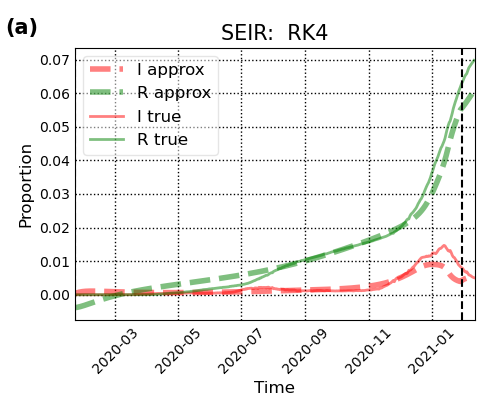

In [46]:
%matplotlib notebook

#plt.style.use('dark_background')
#plt.style.use('ggplot')
x = np.linspace(0, len(SIR)-1, len(SIR))
#fig=plt.figure(figsize=(8, 6))#, facecolor='lightgray')
#ax = fig.add_subplot(111, #facecolor=fcolor, 
#                     axisbelow=True) #'#dddddd'
    
fig,ax=plt.subplots(ncols=1, nrows=1, figsize=(5,4))
fig.subplots_adjust(bottom=0.20, wspace=0.4, left=0.15, right=0.95)

t2=387 #end of prediction window
y_pred = best_model_ode_seir(time[t0:t2])
#ax.plot(x[t0:t2], y_pred[:,0].cpu().data.numpy(), 'y', alpha=0.5, lw=4, linestyle = "--", label='S approx')
ax.plot(dates[t0:t2], y_pred[:,1].cpu().data.numpy(), 'r', alpha=0.5, lw=4, linestyle = "--", label='I approx')
ax.plot(dates[t0:t2], y_pred[:,2].cpu().data.numpy(), 'g', alpha=0.5, lw=4, linestyle = "--", label='R approx')

#ax.plot(x, y_exact[:,0].cpu().data.numpy(), 'y', alpha=0.5, lw=2,  label='S true')
ax.plot(dates[t0:t2], y_exact[t0:t2,1].cpu().data.numpy(), 'r', alpha=0.5, lw=2,  label='I true')
ax.plot(dates[t0:t2], y_exact[t0:t2,2].cpu().data.numpy(), 'g', alpha=0.5, lw=2,  label='R true')
ax.axvline(dates[t1], color = "black", linestyle='dashed')
ax.axvline(dates[t0], color = "black", linestyle='dashed')
ax.set_xlabel('Time', size = 12)
ax.set_ylabel('Proportion', size = 12)
#ax.set_ylim(-0.1,1.2)
#ax.set_xlim(t0-(t1-t0),t2+1)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='k', lw=1, ls=':')
legend = ax.legend(fontsize = 12, loc = 'upper left')
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
#    ax.spines[spine].set_visible(False)
ax.set_title("SEIR:  RK4", size = 15)#
ax.set_xlim(dates[0], dates[t2])
#plt.savefig("SIR_NeuralODE_RK4.png", dpi = 400 , bbox_inches = "tight")
#plt.text(0.10, 0.7, '$\\beta = %5.3f$' % beta, fontsize=14, transform=ax.transAxes)
#plt.text(0.10, 0.6, '$\\gamma = %5.3f$' % gamma, fontsize=14, transform=ax.transAxes)
#plt.show()
#fig.savefig("seir_pde.png", transparent=False)

ax.text(-0.175, 1.05, "(a)", 
    fontweight="bold", 
    fontsize=15, 
    transform=ax.transAxes)

for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    
fig.savefig("seir_pde_const_sigma_prop.pdf")

<IPython.core.display.Javascript object>


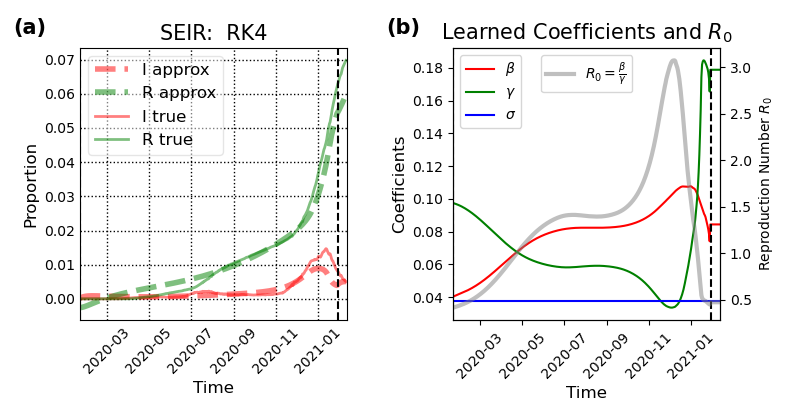

/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/daniel/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
fig2,ax2=pl.subplots(ncols=1, nrows=1, figsize=(5,4))
tm=t1-10
beta[t1-1:] = np.mean(beta[tm:t1-1])
gamma[t1-1:] = np.mean(gamma[tm:t1-1])
sigma[t1-1:] = np.mean(sigma[tm:t1-1])
ax2.plot(dates[0:t2], beta[0:t2], label="$\\beta$", color='red')
ax2.plot(dates[0:t2], gamma[0:t2], label="$\\gamma$", color='green')
#ax2.plot(dates[0:t2], sigma[0:t2], label="$\\sigma$", color='blue')
ax2.plot(dates[0:t2], sigma*np.ones(dates[0:t2].shape), label="$\\sigma$", color='blue')
ax2.legend(loc="upper left")
ax2.set_xlim(dates[t0],dates[t2])
ax2.set_xlabel('Time', size=12)
ax2.set_ylabel('Coefficients', size=12)
ax2.set_title('Learned Coefficients and $R_0$', size=15)
#ax2.grid(b=True, which='major', c='k', lw=1, ls=':')

ax2.set_xlim(dates[0], dates[t2])

ax2.axvline(dates[t1], color = "black", linestyle='dashed')
ax2.axvline(dates[t0], color = "black", linestyle='dashed')
#basic reproduction number R0, from Zhou et al. (2020)
r0=beta/gamma
twinx=ax2.twinx()
twinx.plot(dates, r0, color='gray', linewidth=3, 
           label='$R_0 = \\frac{\\beta}{\\gamma}$', alpha=0.5)
twinx.set_ylabel('Reproduction Number $R_0$')
twinx.legend(loc='upper center')

for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
        
fig.savefig("seir_pde_const_sigma_param.pdf")
        
ax[p].text(-0.25, 1.05, "(b)", 
               fontweight="bold", 
               fontsize=15, 
               transform=ax[p].transAxes)

In [ ]:
r0=beta/gamma

In [ ]:
fig2,ax2=plt.subplots()
ax2.plot(dates,r0)
ax2.set_xlim(dates[t0], dates[t2])

In [ ]:
ax[1].set_xlabel

In [ ]:
ax[2].set_xlabel